Raw processing and looking at REMIND data, which is future predictions of installed capacity.

Import packages

In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os

Load REMIND data sets from raw / future data path

In [141]:
# Load all .mif files from the future folder with REMIND data sets and concatenate them into a single dataframe

def load_all_future_files():
    base_path = Path.cwd().parent
    future_folder = base_path / "data" / "raw" / "future"
    
    dfs = []
    
    for file in future_folder.glob("*.mif"):
        df = pd.read_csv(file, sep=";")
        df["source_file"] = file.stem
        dfs.append(df)
    
    return pd.concat(dfs, ignore_index=True)

future_data = load_all_future_files()

Characterize data set

In [142]:
# Look at head, tail, and random samples from the data set
future_data.head()
future_data.tail()

# Look at shape, column names and index of the data set
future_data.shape
future_data.columns
future_data.index

RangeIndex(start=0, stop=373034, step=1)

Extract data for the needed years and only include wanted region

In [144]:
# Make scenario column with explicit scenaro names
future_data["Scenario"] = future_data["source_file"].str.extract(r"(SSP1|M-SSP2|L-SSP2)")

# New dataframe with only the columns of interest
future_data_2025_2050 = future_data[["Region", "Variable", "Unit", "2025", "2030", "2035", "2040", "2045", "2050", "Scenario"]]

# Only keep rows with the region EUR (European Union) and NEU (Non-European Union in Europe)
future_data_2025_2050 = future_data_2025_2050[future_data_2025_2050["Region"].isin(["EUR", "NEU"])]

# Check data set after filtering
future_data_2025_2050.head()
future_data_2025_2050["Region"].unique()

,Region,Variable,Unit,2025,2030,2035,2040,2045,2050,Scenario
2,EUR,Agricultural Research Intensity,% of Total GDP,0.0195,0.0127,0.0004,0.0080,0.0165,0.0223,L-SSP2
7,NEU,Agricultural Research Intensity,% of Total GDP,0.0149,0.0198,0.0079,0.0058,0.0025,0.0098,L-SSP2
15,EUR,Biodiversity|BII,unitless,0.7285,0.7290,0.7359,0.7365,0.7371,0.7366,L-SSP2
20,NEU,Biodiversity|BII,unitless,0.7890,0.7893,0.7893,0.7893,0.7897,0.7904,L-SSP2
28,EUR,Biodiversity|BII in 30x30 Landscapes,unitless,0.7294,0.7288,0.7343,0.7347,0.7354,0.7309,L-SSP2


Only keep electrolyser stock data, variable Cap|Hydrogen|+|Electricity

In [147]:
# Only keep rows with electrolyser data
future_electrolyser_data = future_data_2025_2050[future_data_2025_2050["Variable"] == "Cap|Hydrogen|+|Electricity"]

# Check data set after filtering
future_electrolyser_data.head()

(6, 10)

Sum capacities per scenario

In [151]:
# Sum up the electrolyser capacity for EUR and NEU to get the total electrolyser capacity in Europe
future_electrolyser_data_years = future_electrolyser_data.groupby("Scenario").sum().reset_index()
future_electrolyser_data_years = future_electrolyser_data_years[["Scenario", "2025", "2030", "2035", "2040", "2045", "2050"]]
future_electrolyser_data_years = future_electrolyser_data_years.melt(id_vars="Scenario", var_name="Year", value_name="Capacity")

# Convert scenarios to columns
future_electrolyser_data_years = future_electrolyser_data_years.pivot(index="Year", columns="Scenario", values="Capacity").reset_index()

# Check data set after summing
future_electrolyser_data_years.head()

Scenario,Year,L-SSP2,M-SSP2,SSP1
0,2025,0.270754,0.270754,0.270754
1,2030,7.943682,6.051640,11.092192
2,2035,31.613359,23.711004,54.733323
3,2040,64.838293,53.896891,130.626293
4,2045,101.749253,91.434296,238.791953


Visualize the data

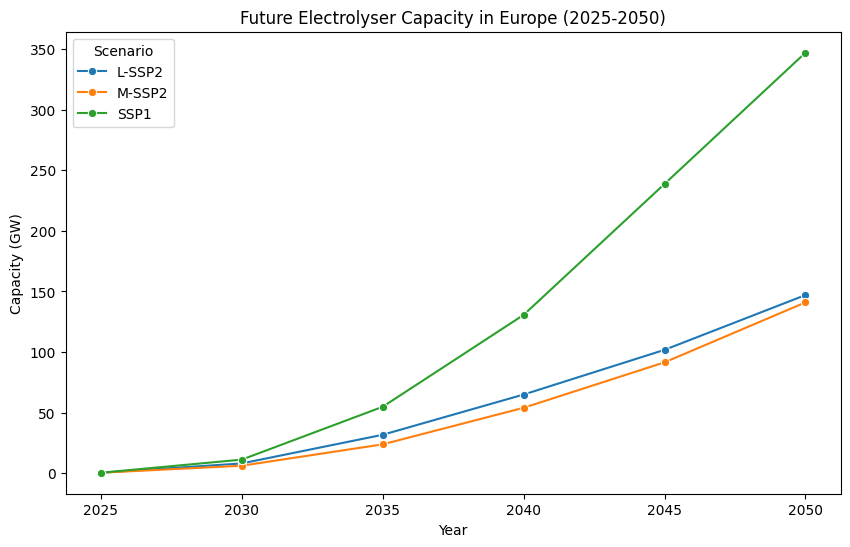

In [156]:
# Visualize the data with a plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=future_electrolyser_data_years, x="Year", y="L-SSP2", marker="o", label="L-SSP2")
sns.lineplot(data=future_electrolyser_data_years, x="Year", y="M-SSP2", marker="o", label="M-SSP2")
sns.lineplot(data=future_electrolyser_data_years, x="Year", y="SSP1", marker="o", label="SSP1")
plt.title("Future Electrolyser Capacity in Europe (2025-2050)")
plt.xlabel("Year")
plt.ylabel("Capacity (GW)")
plt.legend(title="Scenario")
plt.show()

Export data

In [158]:
# Export the future electrolyser data to a csv file
output_path = Path.cwd().parent / "data" / "processed" / "electrolysers" / "future_electrolyser_capacity.csv"
future_electrolyser_data_years.to_csv(output_path, index=False)